# Progression

Progression helps us see how many datasets are enough to get conclusive results from ATE.
Getting datasets can be difficult or expensive, and, in some cases, not possible.
If we want to extract terms from the Superbowl, we would have to wait a year to collect the next dataset.

Knowing when the performance is likely to stop improving or slow down could help projects decide whether to change the approach, or whether more datasets could fine-tune results.

Before exploring the results, we load the required libraries.

In [1]:
import importlib
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import os
import pandas as pd
import sys
import re

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from multiplex import drawable

data = os.path.expanduser('~/DATA/analyses/football/progression-verified/results-new-ap')

We are mostly interested in the overall quality of the ranking, which is measured by the average precision.
However, we consider other evaluation metrics as well.
Therefore from each results file, we load the number of events used to extract terms, and these metrics.
We save these in a dataframe.

In [2]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'events', 'ap', 'precision', 'p@50', 'p@100', 'recall', 'f1' ])

files = os.listdir(data) # the evaluation files
pattern = re.compile("([a-z\-]+)-([0-9]+).json") # the extraction pattern (to get the number of events used to extract terms)

for file in files:
    with open(os.path.join(data, file)) as f:
        results = json.loads(f.readline())
        method, events = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        pk = results['results']['p@k']
        pk = { int(k): p for k, p in pk.items() }
        df.loc[len(df)] = { 'method': method, 'events': int(events),
                            'ap': summary['average precision'], 'precision': summary['precision'],
                            'p@50': (pk[50] if 50 in pk else pk[max(pk.keys())]),
                            'p@100': (pk[100] if 100 in pk else pk[max(pk.keys())]),
                            'recall': summary['recall'], 'f1': summary['f1'] }

df = df.sort_values(by=['method', 'events'])
df = df.reset_index(drop=True)
df.head()

,method,events,ap,precision,p@50,p@100,recall,f1
0,ef-idf-entropy,2,0.007950,0.155,0.20,0.15,0.037576,0.060488
1,ef-idf-entropy,3,0.010353,0.145,0.24,0.17,0.035152,0.056585
2,ef-idf-entropy,4,0.014876,0.180,0.36,0.24,0.043636,0.070244
3,ef-idf-entropy,5,0.017661,0.190,0.38,0.30,0.046061,0.074146
4,ef-idf-entropy,6,0.019881,0.205,0.42,0.25,0.049697,0.080000


**Conclusion:** EF-ICF-Entropy needs more data and learns slower than TF-ICF, but it performs better.

The next visualization shows how differently TF-ICF (with nouns, verbs and adjectives) and EF-ICF-Entropy learn about domains.

EF-ICF-Entropy starts slowly, but learns quickly and consistently.
The quality of its ranking plateaus after about 14 events.

TF-ICF, on the other hand, starts more strongly before dipping.
The dip at around 4 events is due to teams and players being incorrectly identified as nouns, verbs and adjectives.
As the samples get more and more varied, TF-ICF starts recovering.

/home/nicholas/GitHub/multiplex-plot/multiplex/drawable.py:378: UserWarning: FixedFormatter should only be used together with FixedLocator
  return getattr(self.axes, name)(*args, **kwargs)
/home/nicholas/GitHub/multiplex-plot/multiplex/drawable.py:378: UserWarning: FixedFormatter should only be used together with FixedLocator
  return getattr(self.axes, name)(*args, **kwargs)


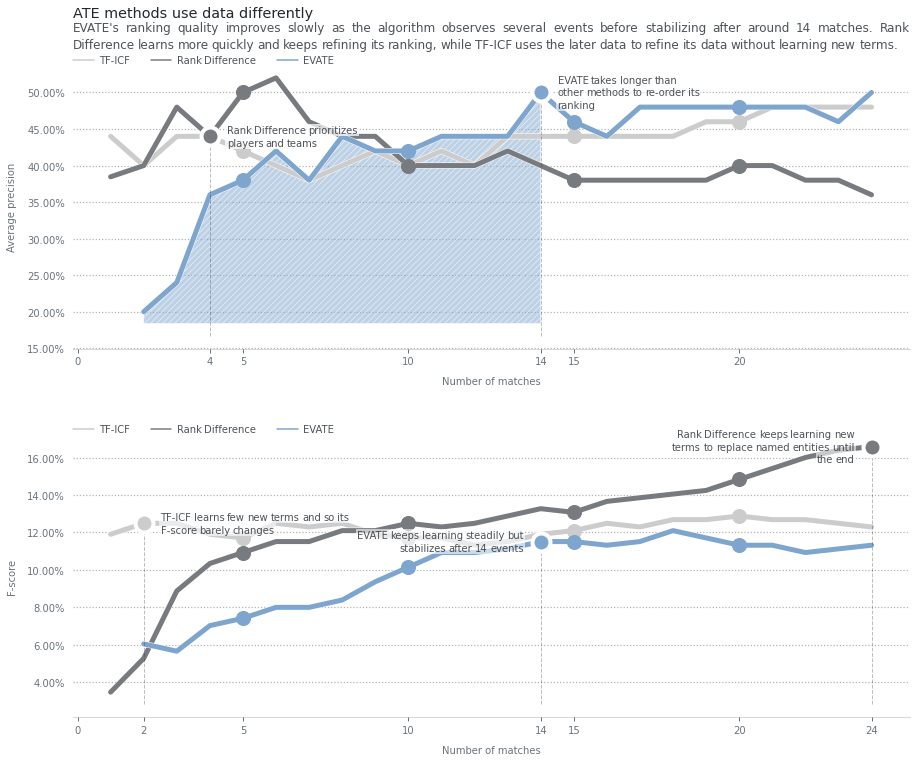

In [3]:
# drawable = importlib.reload(drawable)

m1, n1 = 'tf-idf-nva-rt', 'TF-ICF'
m2, n2 = 'rank-nva-rt', 'Rank Difference'

# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal(), ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }
_annotation_style = dict(annotation_style)
_annotation_style.update({ 'facecolor': '#ffffffbb' }) # used only over shading

# set up the visualization
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,12))

# visualization 1

# prepare the data
at_1, at_2 = 14, 4
metric = 'p@50'

# draw the visualization
viz = drawable.Drawable(figure, ax1)
viz.draw_time_series(df[df.method == m1].events, df[df.method == m1][metric],
                     n1, color='C5', **style)
viz.draw_time_series(df[df.method == m2].events, df[df.method == m2][metric],
                     n2, color='C3', **style)
viz.draw_time_series(df[df.method == 'ef-idf-entropy'].events, df[df.method == 'ef-idf-entropy'][metric],
                     'EVATE', color='C1', **style)

# add markers and shading
markers = range(5, max(df.events), 5)
viz.scatter(markers, df[(df.method == m1) & (df.events.isin(markers))][metric], color='C5', **scatter_style)
viz.scatter(markers, df[(df.method == m2) & (df.events.isin(markers))][metric], color='C3', **scatter_style)
viz.scatter(markers, df[(df.method == 'ef-idf-entropy') & (df.events.isin(markers))][metric], color='C1', **scatter_style)
viz.fill_between(range(2, at_1 + 1), df[(df.method == 'ef-idf-entropy') & (df.events <= at_1) ][metric], viz.get_ylim()[0],
                 hatch='////', color='C1', edgecolor='C4', alpha=0.5)

# annotate
ylim = viz.get_ylim()
ap_at = df[(df.method == 'ef-idf-entropy') & (df.events == at_1) ][metric]
viz.vlines(at_1, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_1, ap_at, color='C1', **annotation_marker_style)
viz.annotate("EVATE takes longer than other methods to re-order its ranking",
             (at_1 + 0.5, at_1 + 5), ap_at, **annotation_style)

ap_at = df[(df.method == m2) & (df.events == at_2) ][metric]
viz.vlines(at_2, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_2, ap_at, color='C3', **annotation_marker_style)
viz.annotate("Rank Difference prioritizes players and teams",
             (at_2 + 0.5, at_2 + 5), ap_at, **_annotation_style)

# finalize the visualization
yticks = [ '{:.2f}%'.format(round(tick * 100, 4)) for tick in viz.get_yticks() ]
viz.set_xticks(list(set(list(range(0, 25, 5)) + [ at_1, at_2 ])))
viz.set_xlabel('Number of matches')
viz.set_ylabel('Average precision')
viz.set_yticklabels(yticks)
viz.set_axisbelow(True)
viz.set_title("ATE methods use data differently", loc='left')
viz.set_caption(f"""EVATE's ranking quality improves slowly as the algorithm observes several events before stabilizing after around { at_1 } matches.
                    Rank Difference learns more quickly and keeps refining its ranking, while TF-ICF uses the later data to refine its data without learning new terms.""",
                align='justify')

# visualization 2

# prepare the data
at_1, at_2, at_3 = 14, 2, df[df.method==m2].events.max()
metric = 'f1'

# draw the visualization
viz = drawable.Drawable(figure, ax2)
viz.draw_time_series(df[df.method == m1].events, df[df.method == m1][metric],
                     n1, color='C5', **style)
viz.draw_time_series(df[df.method == m2].events, df[df.method == m2][metric],
                     n2, color='C3', **style)
viz.draw_time_series(df[df.method == 'ef-idf-entropy'].events, df[df.method == 'ef-idf-entropy'][metric],
                     'EVATE', color='C1', **style)

# add markers and shading
markers = range(5, max(df.events), 5)
viz.scatter(markers, df[(df.method == m1) & (df.events.isin(markers))][metric], color='C5', **scatter_style)
viz.scatter(markers, df[(df.method == m2) & (df.events.isin(markers))][metric], color='C3', **scatter_style)
viz.scatter(markers, df[(df.method == 'ef-idf-entropy') & (df.events.isin(markers))][metric], color='C1', **scatter_style)

# annotate
ylim = viz.get_ylim()
ap_at = df[(df.method == 'ef-idf-entropy') & (df.events == at_1) ][metric]
viz.vlines(at_1, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_1, ap_at, color='C1', **annotation_marker_style)
viz.annotate(f"EVATE keeps learning steadily but stabilizes after { at_1 } events",
             (at_1 - 6.5, at_1 - 0.5), ap_at, align='right', **annotation_style)

ap_at = df[(df.method == m1) & (df.events == at_2) ][metric]
viz.vlines(at_2, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_2, ap_at, color='C5', **annotation_marker_style)
viz.annotate("TF-ICF learns few new terms and so its F-score barely changes",
             (at_2 + 0.5, at_2 + 6.5), ap_at, **annotation_style)

ap_at = df[(df.method == m2) & (df.events == at_3) ][metric]
viz.vlines(at_3, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_3, ap_at, color='C3', **annotation_marker_style)
viz.annotate("Rank Difference keeps learning new terms to replace named entities until the end",
             (at_3 - 6.5, at_3 - 0.5), ap_at, align='right', **annotation_style)

# finalize the visualization
yticks = [ '{:.2f}%'.format(round(tick * 100, 4)) for tick in viz.get_yticks() ]
viz.set_xticks(list(set(list(range(0, 25, 5)) + [ at_1, at_2, at_3 ])))
# viz.set_ylim(min(y), max(y) + 0.015)
viz.set_xlabel('Number of matches')
viz.set_yticklabels(yticks)
viz.set_ylabel('F-score')
viz.set_axisbelow(True)

viz.show()

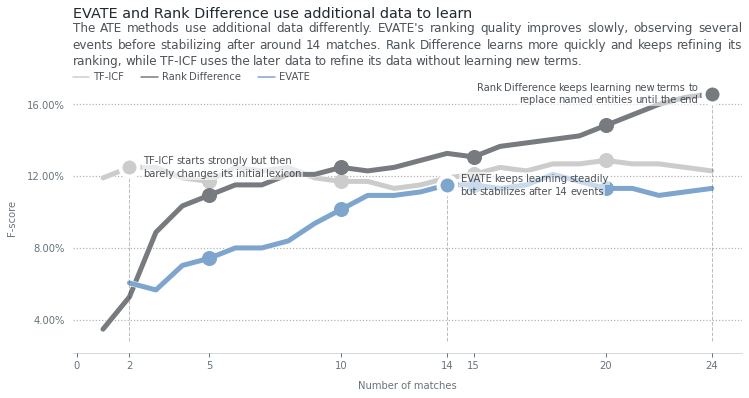

In [4]:
# drawable = importlib.reload(drawable)

m1, n1 = 'tf-idf-nva-rt', 'TF-ICF'
m2, n2 = 'rank-nva-rt', 'Rank Difference'

# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 5, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal(), ] }
marker_style = { 'marker': 'o', 'markersize': 14 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 18, 'markeredgewidth': 4, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }
_annotation_style = dict(annotation_style)
_annotation_style.update({ 'facecolor': '#ffffffbb' }) # used only over shading

# set up the visualization
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

# visualization 1

# prepare the data
at_1, at_2, at_3 = 14, 2, df[df.method==m2].events.max()
metric = 'f1'

# draw the visualization
viz = drawable.Drawable(figure, axes)
viz.draw_time_series(df[df.method == m1].events, df[df.method == m1][metric],
                     n1, color='C5', **style)
viz.draw_time_series(df[df.method == m2].events, df[df.method == m2][metric],
                     n2, color='C3', **style)
viz.draw_time_series(df[df.method == 'ef-idf-entropy'].events, df[df.method == 'ef-idf-entropy'][metric],
                     'EVATE', color='C1', **style)

# add markers and shading
markers = range(5, max(df.events), 5)
viz.scatter(markers, df[(df.method == m1) & (df.events.isin(markers))][metric], color='C5', **scatter_style)
viz.scatter(markers, df[(df.method == m2) & (df.events.isin(markers))][metric], color='C3', **scatter_style)
viz.scatter(markers, df[(df.method == 'ef-idf-entropy') & (df.events.isin(markers))][metric], color='C1', **scatter_style)
# viz.fill_between(range(2, at_1 + 1), df[(df.method == 'ef-idf-entropy') & (df.events <= at_1) ][metric], viz.get_ylim()[0],
#                  hatch='////', color='C1', edgecolor='C4', alpha=0.5)

# annotate
ylim = viz.get_ylim()
ap_at = df[(df.method == 'ef-idf-entropy') & (df.events == at_1) ][metric]
viz.vlines(at_1, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_1, ap_at, color='C1', **annotation_marker_style)
viz.annotate(f"EVATE keeps learning steadily but stabilizes after { at_1 } events",
             (at_1 + 0.5, at_1 + 6.5), ap_at, **annotation_style)

ap_at = df[(df.method == m1) & (df.events == at_2) ][metric]
viz.vlines(at_2, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_2, ap_at, color='C5', **annotation_marker_style)
viz.annotate("TF-ICF starts strongly but then barely changes its initial lexicon",
             (at_2 + 0.5, at_2 + 7), ap_at, **annotation_style)

ap_at = df[(df.method == m2) & (df.events == at_3) ][metric]
viz.vlines(at_3, ymin=ylim[0], ymax=ap_at, **line_style)
viz.plot(at_3, ap_at, color='C3', **annotation_marker_style)
viz.annotate("Rank Difference keeps learning new terms to replace named entities until the end",
             (at_3 - 9, at_3 - 0.5), ap_at, align='right', **annotation_style)

# finalize the visualization
viz.set_yticks([ y/100 for y in range(4, 18, 4) ])
yticks = [ '{:.2f}%'.format(round(tick * 100, 4)) for tick in viz.get_yticks() ]
viz.set_xticks(list(set(list(range(0, 25, 5)) + [ at_1, at_2, at_3 ])))
viz.set_xlabel('Number of matches')
viz.set_ylabel('F-score')
viz.set_yticklabels(yticks)
viz.set_axisbelow(True)
viz.set_title("EVATE and Rank Difference use additional data to learn", loc='left')
viz.set_caption(f"""The ATE methods use additional data differently.
                    EVATE's ranking quality improves slowly, observing several events before stabilizing after around { at_1 } matches.
                    Rank Difference learns more quickly and keeps refining its ranking, while TF-ICF uses the later data to refine its data without learning new terms.""",
                align='justify')

viz.savefig('../exports/4.3-progression-ap-football.png', dpi=300, bbox_inches='tight')

EF-ICF-Entropy's and TF-ICF's rankings vary significantly from each other.
TF-ICF starts very strongly, but tanks almost immediately after.
This phenomenon happens because there is a variety of matches early on.
From each of these matches, TF-ICF captures a few players and team names with a high frequency.

As a result, the top of the ranking is polluted with these names.
When the variation in events increases, domain terms, like _score_ start climbing up above the player and team names, which rarely appear again unless they are participating in the events.
TF-ICF recovers as the number of events increases, but even after 24 events it has not caught up with EF-ICF-Entropy.

EF-ICF-Entropy learns far quicker than TF-ICF, even though it starts off very poorly.
Like TF-ICF, the earlier rankings struggle to distinguish between event and domain terms.
As it gathers more and more events, EF-ICF-Entropy punishes event terms and boosts domain terms.

**Conclusion:** EF-ICF-Entropy learns much more terms than TF-ICF, which uses more data to refine its ranking.

Although TF-ICF seems to recover its form with more events, the next visualization shows that the ranking quality does not improve a lot.
After the initial dip, TF-ICF's F-score takes a long time to start an upwards trend.
By the time that happens, EF-ICF-Entropy has already stabilized.
More significantly, TF-ICF never reverts to its initial results.

This behaviour is very different from EF-ICF-Entropy's.
The latter's performance sets off rather slowly because it too favours player and team names, but it learns rapidly.
'Learns rapidly' here means that, unlike TF-ICF, EF-ICF-Entropy maintains an upward trajectory for a long time.

Why then, does the average precision of TF-ICF increase gradually, but the F-score does not exhibit such behaviour?
The answer is that TF-ICF's improvements are really refining the order of the terms in its rankings by moving relevant terms towards the top.
However, it does not introduce any new and relevant terms to the ranking.
Differently from TF-ICF, EF-ICF-Entropy keeps adding more and more new terms to its lexicon.

## Movement

Another measurement of stability is how volatile the top parts of the rankings are.
The next visualization shows how many terms move in and out of the top rankings as more datasets are added.

The first step is loading the term rankings.

In [5]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'events', 'terms' ])

files = os.listdir(data) # the evaluation files
pattern = re.compile("([a-z\-]+)-([0-9]+).json") # the extraction pattern (to get the number of events used to extract terms)

for file in sorted(files):
    _method, _terms = None, None
    with open(os.path.join(data, file)) as f:
        results = json.loads(f.readline())
        method, events = pattern.findall(file)[0]
        terms = results['pcmd']['terms']        
        df.loc[len(df)] = { 'method': method, 'events': int(events), 'terms': terms }

df = df.sort_values(by=['method', 'events'])
df = df.reset_index(drop=True)    
df.head(10)

,method,events,terms
0,ef-idf-entropy,2,"[hakimi, brandt, gol, reyna, baller, clearanc,..."
1,ef-idf-entropy,3,"[goalkeep, baller, yellow, ball, half, crowd, ..."
2,ef-idf-entropy,4,"[goalkeep, baller, keeper, crowd, half, yellow..."
3,ef-idf-entropy,5,"[goalkeep, baller, keeper, yellow, trim, half,..."
4,ef-idf-entropy,6,"[goalkeep, keeper, baller, yellow, gol, half, ..."
5,ef-idf-entropy,7,"[keeper, goalkeep, baller, yellow, half, ball,..."
6,ef-idf-entropy,8,"[baller, keeper, goalkeep, gol, half, ball, ye..."
7,ef-idf-entropy,9,"[baller, goalkeep, keeper, gol, yellow, ball, ..."
8,ef-idf-entropy,10,"[goalkeep, keeper, baller, gol, yellow, ball, ..."
9,ef-idf-entropy,11,"[keeper, goalkeep, baller, gol, yellow, half, ..."


Next, we compute the movement rankings when adding more events.
The next cell computes two metrics:

- The number of new terms in the top-_k_ ranking
- The movement of terms in the ranking

The difference is that in the latter, position matters: do terms stay in place, or do they tend to jostle around?

In [6]:
# set the threshold and add a new column
k, created = [ 20, 50, 100, 200 ], False
if not created:
    for i, _k in enumerate(k):
        df.insert(3 + i * 3, f"movement-{ _k }", None)
        df.insert(4 + i * 3, f"rank-movement-{ _k }", None)
        df.insert(5 + i * 3, f"avg-rank-movement-{ _k }", None)

for _k in k:
    methods = set(df.method)
    for method in methods:
        _df = df[df['method'] == method]
        _df = _df.reset_index(drop=True)
        movement = [ _k ]
        rank = [ _k ** 2 ]
        for i in range(1, len(_df)):
            _prev = _df.iloc[i-1].terms[:_k]
            _this = _df.iloc[i].terms[:_k]
            movement.append(len(set(_this).difference(set(_prev))))
            rank.append(sum([ abs(r - _prev.index(term)) if term in _prev else _k for r, term in enumerate(_this) ]))

        df.loc[df['method'] == method, f"movement-{ _k }"] = movement
        df.loc[df['method'] == method, f"rank-movement-{ _k }"] = rank
        df.loc[df['method'] == method, f"avg-rank-movement-{ _k }"] = [ r/_k for r in rank ]

df.head()

,method,events,terms,movement-20,rank-movement-20,avg-rank-movement-20,movement-50,rank-movement-50,avg-rank-movement-50,movement-100,rank-movement-100,avg-rank-movement-100,movement-200,rank-movement-200,avg-rank-movement-200
0,ef-idf-entropy,2,"[hakimi, brandt, gol, reyna, baller, clearanc,...",20,400,20,50,2500,50,100,10000,100,200,40000,200
1,ef-idf-entropy,3,"[goalkeep, baller, yellow, ball, half, crowd, ...",3,192,9.6,21,1296,25.92,33,4418,44.18,13,9005,45.025
2,ef-idf-entropy,4,"[goalkeep, baller, keeper, crowd, half, yellow...",6,162,8.1,17,1133,22.66,39,4941,49.41,25,10978,54.89
3,ef-idf-entropy,5,"[goalkeep, baller, keeper, yellow, trim, half,...",4,110,5.5,14,968,19.36,36,4571,45.71,41,14167,70.835
4,ef-idf-entropy,6,"[goalkeep, keeper, baller, yellow, gol, half, ...",4,126,6.3,8,778,15.56,26,3869,38.69,47,14059,70.295


**Conclusion:** EF-ICF-Entropy's ranking has far more movement than TF-ICF's because it keeps adding new words to its vocabulary.

The next visualization continues confirming the previous intuition that TF-ICF refines, and EF-ICF-Entropy learns.
TF-ICF and EF-ICF-Entropy both settle at low rank movements, but by the end, EF-ICF-Entropy has more than three times the movement of TF-ICF.
EF-ICF-Entropy is not necessarly refining the ranking.
In fact, the average precision does not increase, unlike the F-score metric has more movement.
This indicates that EF-ICF-Entropy is introducing new terms to its ranking.

It is this movement that makes it possible for EF-ICF-Entropy to dynamically learn about domains.

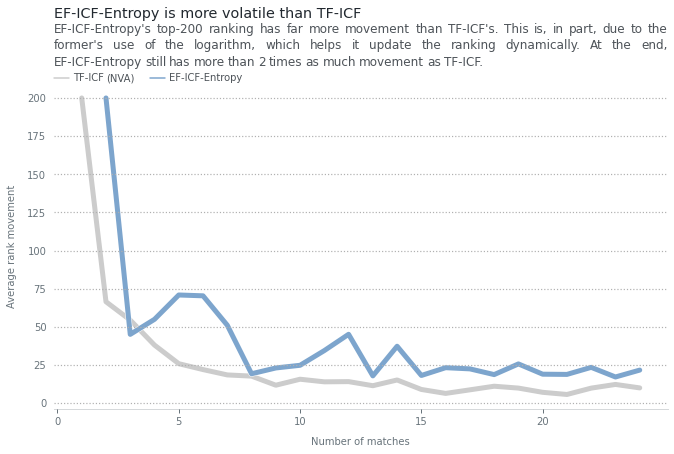

In [7]:
drawable = importlib.reload(drawable)

# draw the visualization
figure = plt.figure(figsize=(11, 6))
viz = drawable.Drawable(figure)
x1, y1 = df[df.method == 'tf-idf-nva-rt'].events, df[df.method == 'tf-idf-nva-rt'][f"avg-rank-movement-{ k[-1] }"].tolist()
x2, y2 = df[df.method == 'ef-idf-entropy'].events, df[df.method == 'ef-idf-entropy'][f"avg-rank-movement-{ k[-1] }"].tolist()
viz.draw_time_series(x1, y1,
                     'TF-ICF (NVA)', color='C5', **style)
viz.draw_time_series(x2, y2,
                     'EF-ICF-Entropy', color='C1', **style)

# finalize the visualization
viz.set_xticks(list(range(0, 25, 5)))
viz.set_xlabel('Number of matches')
viz.set_ylabel('Average rank movement')
viz.set_title("EF-ICF-Entropy is more volatile than TF-ICF", loc='left')
viz.set_caption(f"""EF-ICF-Entropy's top-{ k[-1] } ranking has far more movement than TF-ICF's.
                    This is, in part, due to the former's use of the logarithm, which helps it update the ranking dynamically.
                    At the end, EF-ICF-Entropy still has more than { math.floor(y2[-1]/y1[-1])} times as much movement as TF-ICF.""",
                align='justify')
viz.savefig('../exports/4.3-progression-movement.png', dpi=300, bbox_inches='tight')

## What does that actually mean though?

Looking at the volatility, you might feel alarm: shouldn't the ranking stabilize and converge?
How do we know that the rankings are not being spoiled?
It's easier to understand what is happening by looking at how individual terms move around in the rankings.

First, we look for a particular term's place in both TF-ICF's and EF-ICF-Entropy's rankings.
We choose the term _handball_ because it is rather technical and uncommon.
Therefore it pits TF-ICF's behavior against EF-ICF-Entropy because it requires patience to learn that it is indeed relevant to the domain.

In [8]:
# prepare the data
term = 'handbal'
y = { }
for method in methods:
    y[method] = [ ]
    _df = df[df['method'] == method]
    _df = _df.reset_index(drop=True)
    for i in range(len(_df)):
        y[method].append(_df.iloc[i].terms.index(term) + 1 if term in _df.iloc[i].terms else 1000)

# print(df[(df['method'] == 'tf-idf-nva-rt') & (df['events'] == 2)].iloc[0].terms)

**Conclusion:** EF-ICF-Entropy learns similarly to spaced repetition.

The next visualization shows exactly how TF-ICF and EF-ICF-Entropy differ.
TF-ICF never even captures the term _handball_.
Conversely, although it takes EF-ICF-Entropy 10 matches to identify _handball_ as a domain term, but once it appears in the rankings, it never disappears again.
Not only that, but even though it is uncommon, it gradually climbs up the ranking to finally find a place among the top 50 terms.

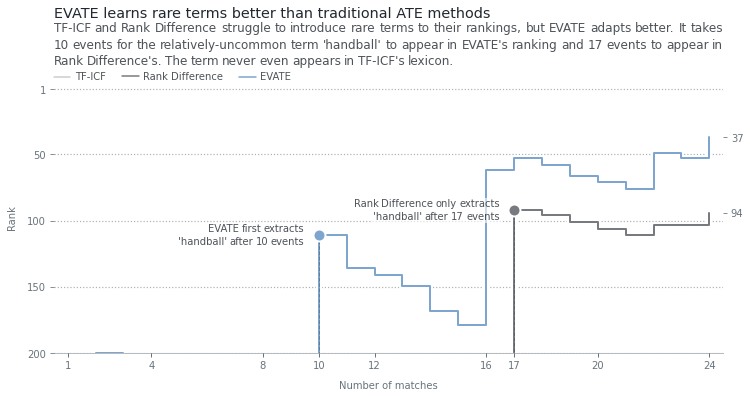

In [9]:
# update the style
style.update({ 'linewidth': 2 })
marker_style.update({ 'markersize': 10 })
annotation_marker_style.update({ 'markersize': 12, 'markeredgewidth': 2, 'markeredgecolor': 'C4' })

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

_x, _y = df[df['method'] == 'tf-idf-nva-rt'].events.tolist(), y['tf-idf-nva-rt']
viz.draw_time_series(_x, _y, 'TF-ICF', drawstyle='steps-post', color='C5', linestyle='-', **style)

_x, _y = df[df['method'] == 'rank-nva-rt'].events.tolist(), y['rank-nva-rt']
viz.draw_time_series(_x, _y, 'Rank Difference', drawstyle='steps-post', color='C3', **style)
a1 = [ (__x, __y) for __x, __y in zip(_x, _y) if __y < 200 ][0]

_x, _y = df[df['method'] == 'ef-idf-entropy'].events.tolist(), y['ef-idf-entropy']
viz.draw_time_series(_x, _y, 'EVATE', drawstyle='steps-post', color='C1', **style)
a2 = [ (__x, __y) for __x, __y in zip(_x, _y) if __y < 200 ][0]

# annotate
ylim = viz.get_ylim()
viz.vlines(a2[0], ymin=a2[1], ymax=200, **line_style)
viz.plot(a2[0], a2[1], color='C1', **annotation_marker_style)
viz.annotate(f"EVATE first extracts 'handball' after { a2[0] } events",
             (a2[0] - 5.5, a2[0] - 0.5), a2[1], align='right', **annotation_style)


viz.vlines(a1[0], ymin=a1[1], ymax=200, **line_style)
viz.plot(a1[0], a1[1], color='C3', **annotation_marker_style)
viz.annotate(f"Rank Difference only extracts 'handball' after { a1[0] } events",
             (a1[0] - 6, a1[0] - 0.5), a1[1], align='right', **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
viz.set_xticks(list(set([ 1, a1[0], a2[0] ] + list(range(4, max(_x) + 1, 4)))))
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Number of matches')
viz.set_ylabel('Rank')
viz.invert_yaxis()
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][-1] for method in y ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_axisbelow(True)
viz.set_title("EVATE learns rare terms better than traditional ATE methods", loc='left')
viz.set_caption(f"""TF-ICF and Rank Difference struggle to introduce rare terms to their rankings, but EVATE adapts better.
                    It takes { a2[0] } events for the relatively-uncommon term 'handball' to appear in EVATE's ranking and { a1[0] } events to appear in Rank Difference's.
                    The term never even appears in TF-ICF's lexicon.""",
                align='justify')
viz.savefig('../exports/4.3-progression-learn.png', dpi=300, bbox_inches='tight')

Learning works both ways.
In the next example, we show how EF-ICF-Entropy doesn't just learn what is relevant, but also what isn't relevant.
We focus on the non-term _Arsenal_ next.
Although it is a named entity, Twitter's erratic orthography means that there are enough misspellings for it to pass off as a noun and trick TF-ICF.

In [10]:
# prepare the data
term = 'arsen'
y = { }
for method in methods:
    y[method] = [ ]
    _df = df[df['method'] == method]
    _df = _df.reset_index(drop=True)
    for i in range(len(_df)):
        y[method].append(_df.iloc[i].terms.index(term) + 1 if term in _df.iloc[i].terms else 1000)

**Conclusion:** Movement is not a bad thing: it's what EF-ICF-Entropy uses to drop irrelevant terms.

The next visualization of _Arsenal_'s ranking shows how TF-ICF, in spite of its linguistic component, still ranks Arsenal very highly.
Conversely, EF-ICF-Entropy hesitates to move the term up the ranking.
More importantly than that, however, the figure demonstrates two points that again set apart TF-ICF and EF-ICF-Entropy.

First, movement is not inherently a bad thing.
Although EF-ICF-Entropy has more movement than TF-ICF, that is because it is constantly evaluating which words are good candidates to be terms.
Differently from EF-ICF-Entropy, TF-ICF is more static, which keeps it from introducing new terms, and for removing incorrect terms.

Second, even though EF-ICF-Entropy does not have POS-based filtering, it is robust.
The algorithm rarely captures named entities because its linguistic filtering, which uses TDT to pick out candidate terms, has a stronger justification than POS-based filtering.
In the events when it does, as is the case with _Arsenal_ due to the team's popularity, it penalizes them strongly.
This is largely thanks to entropy and event frequency, which recognize that the candidate term behaves more like an event term than a domain term.

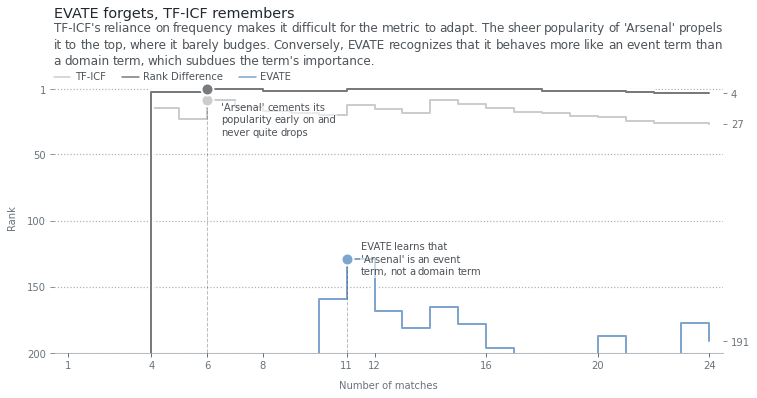

In [11]:
# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

_x, _y = df[df['method'] == 'tf-idf-nva-rt'].events.tolist(), y['tf-idf-nva-rt']
viz.draw_time_series(_x, _y, 'TF-ICF', drawstyle='steps-post', color='C5', linestyle='-', **style)
_max_2 = min([ (__x, __y) for __x, __y in zip(_x, _y) if __y < 200 ], key=lambda _xy: _xy[1])

_x, _y = df[df['method'] == 'rank-nva-rt'].events.tolist(), y['rank-nva-rt']
viz.draw_time_series(_x, _y, 'Rank Difference', drawstyle='steps-post', color='C3', **style)
_max_3 = min([ (__x, __y) for __x, __y in zip(_x, _y) if __y < 200 ], key=lambda _xy: _xy[1])

_x, _y = df[df['method'] == 'ef-idf-entropy'].events.tolist(), y['ef-idf-entropy']
viz.draw_time_series(_x, _y, 'EVATE', drawstyle='steps-post', color='C1', **style)
_max_1 = min([ (__x, __y) for __x, __y in zip(_x, _y) if __y < 200 ], key=lambda _xy: _xy[1])

# annotate
ylim = viz.get_ylim()
viz.vlines(_max_1[0], ymin=_max_1[1], ymax=200, **line_style)
viz.plot(_max_1[0], _max_1[1], color='C1', **annotation_marker_style)
viz.annotate("EVATE learns that 'Arsenal' is an event term, not a domain term",
             (_max_1[0] + 0.5, _max_1[0] + 5), _max_1[1], **annotation_style)

viz.vlines(_max_2[0], ymin=min(_max_2[1], _max_3[1]), ymax=200, **line_style)
viz.plot(_max_2[0], _max_2[1], color='C5', **annotation_marker_style)
viz.plot(_max_3[0], _max_3[1], color='C3', **annotation_marker_style)
viz.annotate("'Arsenal' cements its popularity early on and never quite drops",
             (_max_2[0] + 0.5, _max_2[0] + 5), _max_2[1] + 15, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
viz.set_xticks(list(set([ 1, _max_1[0], _max_2[0] ] + list(range(4, max(_x) + 1, 4)))))
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Number of matches')
viz.set_ylabel('Rank')
viz.invert_yaxis()
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][-1] for method in y ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_axisbelow(True)
viz.set_title("EVATE forgets, TF-ICF remembers", loc='left')
viz.set_caption(f"""TF-ICF's reliance on frequency makes it difficult for the metric to adapt.
                    The sheer popularity of 'Arsenal' propels it to the top, where it barely budges.
                    Conversely, EVATE recognizes that it behaves more like an event term than a domain term, which subdues the term's importance.""",
                align='justify')
viz.savefig('../exports/4.3-progression-forget.png', dpi=300, bbox_inches='tight')